In [ ]:
!pip install transformers==4.4.2
!pip install seqeval==1.2.2
!pip install ujson==4.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.1 MB/s 
     |████████████████████████████████| 880 kB 30.9 MB/s 
     |████████████████████████████████| 3.3 MB 35.7 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=c60b57b73f9ccdac744d6f16ba64538318df283b75f7665c978665281abb531a
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.4 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=17c7274dc856aff6c034ff1435109da82ae8a2d0c160fa71fcb8d839a30b2269
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully buil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from transformers import BertForTokenClassification, BertTokenizer, AutoModelForTokenClassification
import torch
import numpy as np
# from dataset import HPODataset
from utils import bio_to_entity_tokens, character_annotations_to_spacy_doc
import spacy
from spacy import displacy

ModuleNotFoundError: ignored

In [ ]:
data_file = "/content/drive/MyDrive/Colab Notebooks/VABert/data/annotatedVA.jsonl"
device = 'cpu'
model_checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/VABert/Model/hponer_epoch296_f1_0.9558'
bert_type = "dmis-lab/biobert-v1.1"

In [ ]:
from typing import List
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from utils import tokenize_and_preserve_labels, view_all_entities_terminal

import spacy
import srsly
from utils import character_annotations_to_spacy_doc, get_iob_labels


# TODO: Add docstring to functions

class HPODataset(Dataset):
	def __init__(self, filename:str) -> None:
		ann_file = srsly.read_jsonl(filename)
		anns = [annotation for annotation in ann_file]
		nlp = spacy.load('/content/drive/MyDrive/Colab Notebooks/VABert/tokenizers/super-tokenizer')

		self.sentences = []
		self.tags = []
		for ann in anns:
			try:
				doc = character_annotations_to_spacy_doc(ann, nlp)
			except: # when spans overlapped # TODO: handle this
				continue
			bio = get_iob_labels(doc)
			self.sentences.append([str(word) for word in doc])
			self.tags.append(bio)
		self.tag_values = ['O', 'B-VA', 'I-VA', 'B-Vision', 'I-Vision', 'B-Laterality', 'I-Laterality', 'B-pinhole', 'I-pinhole'] # TODO: bad handling, need optimization
		self.tag_values.append("PAD")
		self.tag2idx = {t: i for i, t in enumerate(self.tag_values)}
		self.anns = anns # this format is useful for some function (e.g. viewing entities in terminal)

	def __len__(self) -> int:
		assert len(self.sentences) == len(self.tags)
		return len(self.sentences)

	def __getitem__(self, index: int):
		return self.sentences[index], self.tags[index]

	def set_params(self, tokenizer, max_len, batch_size, val_size, seed):
		"""Set parameters for the Dataset
		Note: this function must be called before others

		Args:
			val_size (float): portion of validation set [0 - 1]
			seed (int): seed for randomization
			batch_size (int): batch size
			max_len (int): maximal length of the input vector (affecting padding)
			tokenizer (BertTokenizer): BERT tokenizer
		"""
		self.tokenizer = tokenizer
		self.VAL_SIZE = val_size
		self.SEED = seed
		self.BATCH_SIZE = batch_size
		self.MAX_LEN = max_len
		self.TOKENIZER = tokenizer

	def get_dataloaders(self, sents, tags, mode='split'):
		"""Return train and val dataloaders
		split -> tokenize -> pad -> [Dataloaders]

		mode [str]: 'split' or 'all' # TODO: add details
		"""
		if mode == 'split':
			# Split
			train_sents, valid_sents, train_tags, valid_tags = train_test_split(self.sentences, self.tags,
																	random_state=self.SEED,
																	test_size=self.VAL_SIZE)

			# make dataloaders
			tokenized_train_sents, tokenized_train_tags, train_dataloader = self.make_dataloader(train_sents, train_tags)
			tokenized_valid_sents, tokenized_valid_tags, valid_dataloader = self.make_dataloader(valid_sents, valid_tags)

			# for later use
			self.train_sents = train_sents; self.train_tags = train_tags
			self.valid_sents = valid_sents; self.valid_tags = valid_tags
			self.tokenized_train_sents = tokenized_train_sents; self.tokenized_train_tags = tokenized_train_tags
			self.tokenized_valid_sents = tokenized_valid_sents; self.tokenized_valid_tags = tokenized_valid_tags
			return train_dataloader, valid_dataloader

		elif mode == 'all':
			_, _, dataloader = self.make_dataloader(sentences, tags)
			return dataloader
		else:
			print('Error: please select mode') # TODO: Add raising error here

	def make_dataloader(self, sents, tags):
		# Tokenizing
		tokenized_sents, tokenized_tags = self._tokenize(sents, tags)

		# Padding
		inputs, tags_pad, masks = self._pad(tokenized_sents, tokenized_tags)

  		# Tensorizing
		inputs_ts = torch.tensor(inputs)
		tags_ts = torch.tensor(tags_pad)
		masks_ts = torch.tensor(masks)

		# Dataloaders
		data = TensorDataset(inputs_ts, masks_ts, tags_ts)
		sampler = RandomSampler(data)
		dataloader = DataLoader(data, sampler=sampler, batch_size=self.BATCH_SIZE)

		return tokenized_sents, tokenized_tags, dataloader


	def get_splitted(self):
		return  (self.train_sents, self.train_tags), (self.valid_sents, self.valid_tags)

	def get_tokenized(self):
		"""Get tokenized sentences and corresponding tags from train and validation set
		Prerequisite: get_dataloaders()

		Returns:
			tokenized train set (Tuple): train sentences and corresponding tags
   			tokenized valid set (Tuple): valid sentences and corresponding tags
		"""
		return (self.train_sents, self.train_tags), (self.valid_sents, self.valid_tags)

	def get_tag_info(self):
		return self.tag2idx, self.tag_values

	def stats(self, verbose=False):
		"""Get basics statistics of the dataset
		"""
		num_sent_has_ent = 0
		num_ent = 0
		for i in range(len(self.tags)):
			tag = self.tags[i]
			sent = self.sentences[i]
			if set(tag) != set('O'):	# sentence with all Os will have set(tag) == {'O'}
				num_sent_has_ent += 1
				num_ent += tag.count('B-pnt')

		if verbose:
			if set(tag) != set('O'):
				print(tag)
				print(tag.count('B-pnt'), ' | ', num_ent)
			else:
				print('#####', tag)
			print()

		print('Total sentences: ', len(self.sentences))
		print('No. of sentences that have entities: ', num_sent_has_ent)
		print('No. of sentences that have no entities (all Os): ', len(self.sentences) - num_sent_has_ent)
		print('No. of entities: ', num_ent)
		print('No. of entities/sentences: ', num_ent/num_sent_has_ent)

	def view_ents(self, index=None):
		if index is not None:
			sent = self.anns[index]
			print(view_all_entities_terminal(sent['text'], sent['spans']))
		else:
			for sent in self.anns: # show all
				print(view_all_entities_terminal(sent['text'], sent['spans']))

	def _tokenize(self, sents: List[List], tags: List[List], tokenizer=None):
		"""Tokennize the sentences

		Args:
			sents (List[List]): Sentences to be tokenized
			tags (List{List]): Corresponding tags
			tokenizer: tokenizer, eg BertTokenizer

		Returns:
			[type]: [description]
		"""
		if tokenizer is None:
			tokenizer = self.tokenizer

		tokenized_texts_and_labels = [
			tokenize_and_preserve_labels(sent, labs, tokenizer)
			for sent, labs in zip(sents, tags)
		]

		tokenized_sents = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
		tokenized_tags = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]
		return tokenized_sents, tokenized_tags

	def _pad(self, tokenized_sents: List[List], tokenized_tags: List[List], max_len=None):
		"""Padding

		Args:
			tokenized_sents (List[List]): list of tokenized sentences
			tokenized_tags (List[List]): list of corresponding tags
			max_len (int): maximum length of the vector after padded

		Returns:
			input_id:
			tags:
			attention_maks:
		"""
		if max_len is None:
			max_len = self.MAX_LEN

		input_ids = pad_sequences([self.tokenizer.convert_tokens_to_ids(sent) for sent in tokenized_sents],
								maxlen=max_len, dtype="long", value=0.0,
								truncating="post", padding="post")

		tags = pad_sequences([[self.tag2idx.get(t) for t in tag] for tag in tokenized_tags],
							maxlen=max_len, value=self.tag2idx["PAD"], padding="post",
							dtype="long", truncating="post")

		attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]
		return input_ids, tags, attention_masks


if __name__ == '__main__':
	import json
	from transformers import BertTokenizer
	from argparse import Namespace

	params = json.load(open('/content/drive/MyDrive/Colab Notebooks/VABert/config/train_config.json', 'r'))
	p = Namespace(**params)

	# Load data
	dataset = HPODataset(data_file)

	#  Tokenize and Pad
	tokenizer = BertTokenizer.from_pretrained(p.CHECKPOINT, do_lower_case=False)
	dataset.set_params(tokenizer=tokenizer,
						max_len=p.MAX_LEN,
						batch_size=p.BATCH_SIZE,
						val_size=p.VAL_SIZE,
						seed=p.SEED
	)

	# Dataloaders
	# train_dataloader, valid_dataloader = dataset.get_dataloaders()


/usr/local/lib/python3.7/dist-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_super-tokenizer' (0.0.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/content/utils.py:86: UserWarning: Skipping entity [732, 751, Vision] in the following text because the character span 'glasses correction ' does not align with token boundaries:

'Thank you very much for re-referring this 78 year old man who was reviewed in the Cataract Service today.   He has visually significant right cataract and should benefit from surgery.   His visual acuity was  right 6/12 and 6/9 left.  After a discussion of the benefits and risks of surgery he elected to proceed with surgery and has been listed for: right phakoemulsification an

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

In [ ]:
tag_values

['O',
 'B-VA',
 'I-VA',
 'B-Vision',
 'I-Vision',
 'B-Laterality',
 'I-Laterality',
 'B-pinhole',
 'I-pinhole',
 'PAD']

In [ ]:
dataset = HPODataset(data_file)   
tag2idx, tag_values = dataset.get_tag_info()

/usr/local/lib/python3.7/dist-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_super-tokenizer' (0.0.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/content/utils.py:86: UserWarning: Skipping entity [732, 751, Vision] in the following text because the character span 'glasses correction ' does not align with token boundaries:

'Thank you very much for re-referring this 78 year old man who was reviewed in the Cataract Service today.   He has visually significant right cataract and should benefit from surgery.   His visual acuity was  right 6/12 and 6/9 left.  After a discussion of the benefits and risks of surgery he elected to proceed with surgery and has been listed for: right phakoemulsification an

In [ ]:
tokenizer = BertTokenizer.from_pretrained(bert_type, do_lower_case=False)
model = BertForTokenClassification.from_pretrained(model_checkpoint_path, num_labels=10)

In [ ]:
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.1 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=4e26cf5258ccab68afcc8758069e80bf09f5532a4b4461010aedb363f6f88a84
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
#F1
from seqeval.metrics import accuracy_score, precision_score, recall_score
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score

In [ ]:
df1 = df.copy()


In [ ]:
df1[12]

'O'

In [ ]:
df1[12] = 'O'

In [ ]:
f1_score([df], [df])

1.0

In [ ]:
len(a)

6658

In [ ]:
test_sentence = "The patient has the vision in uncorrected RE 6/6 and LE NLP vision and without glasses 4/6 on both eyes and a history of severe nyctalopia and macular atrophy."

In [ ]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cpu()

NameError: ignored

In [ ]:
model.eval()
# Predict
with torch.no_grad():
	output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

# # join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
	if token not in ['[CLS]', '[SEP]', '[PAD]']:
		if token.startswith("##"):
			new_tokens[-1] = new_tokens[-1] + token[2:]
		else:
			new_labels.append(tag_values[label_idx])
			new_tokens.append(token)

In [ ]:
df = []
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))
    df.append(label)

O	The
O	patient
O	has
O	the
O	vision
O	in
O	uncorrected
B-Laterality	RE
B-VA	6
I-VA	/
I-VA	6
O	and
B-Laterality	LE
B-VA	NLP
O	vision
O	and
O	without
B-Vision	glasses
B-VA	4
I-VA	/
I-VA	6
O	on
B-Laterality	both
O	eyes
O	and
O	a
O	history
O	of
O	severe
O	nyctalopia
O	and
O	macular
O	atrophy
O	.


In [ ]:
import pandas as pd
visual = pd .DataFrame(df)
# visual

In [1]:
from pathlib import Path
import re

file_path = Path('VA.conll')
raw_text = file_path.read_text().strip()
raw_docs = re.split(r'\n\t?\n', raw_text)
token_docs = []
tag_docs = []
for doc in raw_docs:
    tokens = []
    tags = []
    for line in doc.split('\n'):
      token, tag = line.replace(' _ ', "").split('-X-')
      tokens.append(token)
      tags.append(tag)
    token_docs.append(tokens)
    tag_docs.append(tags)
for i,j in zip(token_docs[0], tag_docs[0]):
  i,j

FileNotFoundError: ignored

In [ ]:
count.items()

NameError: ignored

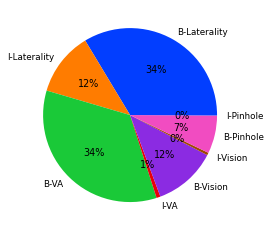

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#define data
data = [1228, 432, 1259, 27, 428, 17, 258, 3]
labels = ['B-Laterality','I-Laterality', 'B-VA','I-VA','B-Vision','I-Vision','B-Pinhole','I-Pinhole']

#define Seaborn color palette to use
colors = sns.color_palette('bright')[0:7]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [ ]:
titanic = pd.DataFrame({'Entities':b, 'labels':a})

NameError: ignored

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
sns.set_context('paper')

# # load dataset
# titanic = sns.load_dataset('titanic')
# print(titanic.head())

# create plot
sns.countplot(x = 'Entities', hue = 'labels', data = titanic, palette = 'magma')
plt.title('Visual Acuity frequencies')
plt.show()

NameError: ignored

In [2]:
from pathlib import Path
import re

file_path = Path('VA.conll')
raw_text = file_path.read_text().strip()
raw_docs = re.split(r'\n\t?\n', raw_text)
token_docs = []
tag_docs = []
VAs = []
for doc in raw_docs:
    tokens = []
    tags = []
    for line in doc.split('\n'):
      # print(line)
      token, tag = line.replace(' _ ', "").split('-X-')
      if tag == 'O' or tag== ' O':
        pass
      else:
        # print(tag)
        if tag.split('-')[1] == 'VA' or tag.split('-')[1] == 'Pinhole':
          # print(token)
          pattern = re.compile(r'^&v=[0-9]+$')
          if pattern.findall(token):
              pass
          else:
              print(token)
              VAs.append(token)
        
      tokens.append(token)
      tags.append(tag)
    token_docs.append(tokens)
    tag_docs.append(tags)
for i,j in zip(token_docs[0], tag_docs[0]):
  i,j

6/12 
6/18 
right6/24 
6/18. 
PL 
6/6 
6/24 
PL 
6/6 
6/12 
6/4 
6/12 
6/18 
6/12 
6/9 
3/60 
6/9 
6/9 
6/9 
6/12 
6/9 
3/60 
6/18 
and6/6-3 
Counting 
finger 
2/60 
6/9+1 
6/9 
6/6. 
6/12. 
6/9 
6/36 
6/18 
6/9 
6/12 
6/9 
6/12 
6/18 
6/9 
6/6 
6/9 
Hand 
Movements 
6/36 
6/9 
6/9 
6/5 
6/4 
6/9 
6/24 
6/18+2 
6/12 
6/12 
6/18 
6/24 
6/6 
6/12 
0.100 
logMAR 
1.100 
6/24 
6/18 
6/18 
6/6 
6/24 
6/12 
6/12 
6/12 
NPL 
6/12 
6/18 
6/5 
6/5 
6/9 
6/9 
6/18 
CF 
6/12 
6/36 
6/9 
6/9 
6/5 
6/5 
6/9 
6/9 
HM 
1/60 
6/6 
6/9 
NPL 
Unaided 
6/36 
Unaided, 
6/5 
6/9 
6/60 
6/36-1, 
6/9 
6/6 
6/9. 
3/60 
3/60 
6/9 
6/9 
6/18 
6/6 
6/5 
6/60 
6/60 
6/9part 
6/24 
6/18 
6/18 
6/6 
6/9 
6/18 
6/9 
6/24 
6/6 
6/9 
6/9 
6/4 
6/4 
6/12 
6/24 
HM 
6/6 
6/9 
6/6 
6/9 
6/6 
6/6 
6/9 
3/60 
6/9 
6/24 
6/6 
6/12-1 
6/6 
6/6 
6/36 
6/6 
6/96 
6/9 
2/60 
6/12 
6/12 
6/5 
6/9 
6/6 
6/9 
6/18 
6/6 
6/6 
CF 
6/6 
6/6 
6/5 
6/36 
6/12 
6/5 
6/24 
6/6 
6/5 
6/12 
6/12 
6/9 
6/6 
CF 
6/18 
6/9 
6/36 
6/12 
6/9 
6

In [3]:
len(VAs)

1547

In [4]:
from collections import Counter
dic = Counter(VAs)

In [5]:
myVA = []
for key, value in dic.items():
    if value >10:
      myVA.append(key)
myVA

['6/12 ',
 '6/18 ',
 '6/6 ',
 '6/24 ',
 '6/9 ',
 '3/60 ',
 '2/60 ',
 '6/36 ',
 '6/5 ',
 'CF ',
 'HM ',
 '1/60 ',
 '6/60 ']

In [6]:
VA = []

In [7]:
for i in VAs:
  if i in myVA:
    i.replace('.','')
    VA.append(i)

In [ ]:
d = {}
for i in VA:
  if i not in d.keys():
    d[i] = 1
  else:
    d[i] +=1
del d['1/60 ']
d = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))

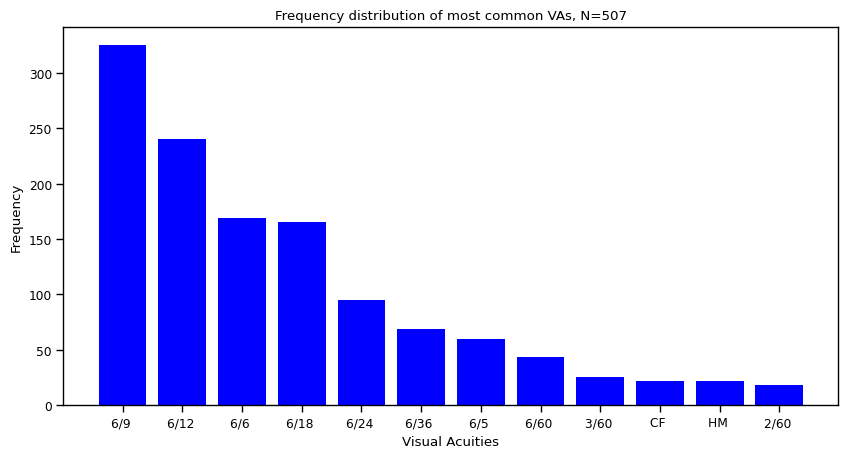

In [ ]:
plt.bar(d.keys(), d.values(), color='b')
plt.gca().set(title='Frequency distribution of most common VAs, N=507', ylabel='Frequency', xlabel = 'Visual Acuities');

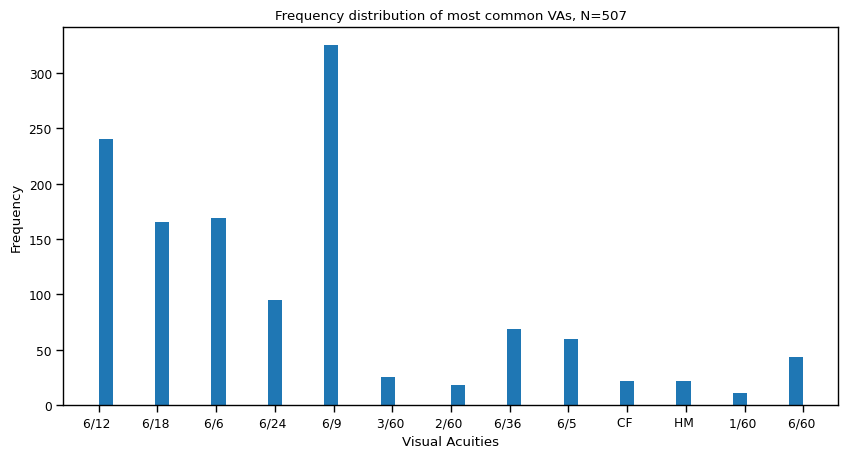

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':100})

# Plot Histogram on x
plt.hist(VA, bins=50)
plt.gca().set(title='Frequency distribution of most common VAs, N=507', ylabel='Frequency', xlabel = 'Visual Acuities');

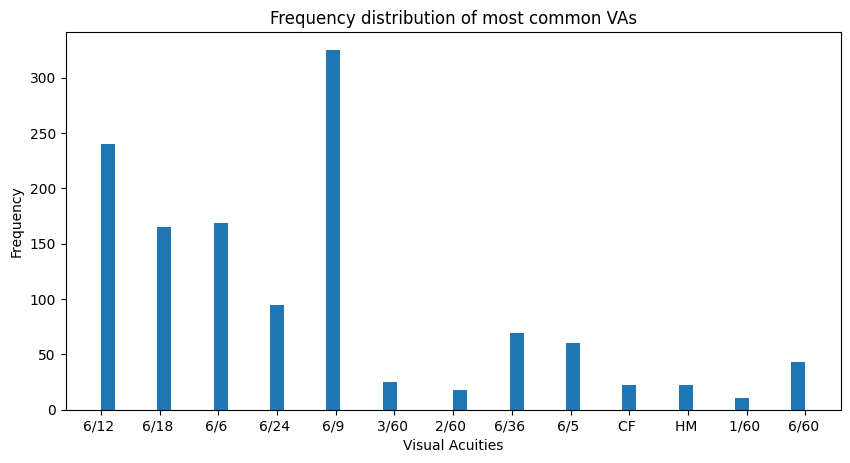

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':100})

# Plot Histogram on x
plt.hist(VA, bins=50)
plt.gca().set(title='Frequency distribution of most common VAs', ylabel='Frequency', xlabel = 'Visual Acuities');

In [ ]:
1232*2 + 27

2491

In [ ]:
255*2+3

513

In [ ]:
titanic

,data,labels
0,1228,B-Laterality
1,432,I-Laterality
2,1259,B-VA
3,27,I-VA
4,428,B-Vision
5,17,I-Vision
6,258,B-Pinhole
7,3,I-Pinhole


In [13]:
file_path = Path('VAnotes.txt')
letters = file_path.read_text().split("\n")

In [21]:
lis = []
for letter in letters:
  if 'year old' in letter:
    idx = letter.index('year old')
    age = letter[idx-3: idx-1]
    try:
      lis.append(int(age))
    except:
      pass
    # lis.append(letter)
len(lis)

676

In [24]:
sum(lis)/len(lis)

66.17307692307692

In [ ]:
count = {}
for token in tag_docs:
  for label in token:
    if label not in count.keys():
      count[label] = 1
    else:
      count[label] +=1

In [ ]:
from pathlib import Path
import re

file_path = Path('VA.conll')
raw_text = file_path.read_text().strip()
raw_docs = re.split(r'\n\t?\n', raw_text)
token_docs = []
tag_docs = []
VAs = []
for doc in raw_docs:
    tokens = []
    tags = []
    for line in doc.split('\n'):
      # print(line)
      token, tag = line.replace(' _ ', "").split('-X-')
      if tag == 'O' or tag== ' O':
        pass
      else:
        # print(tag)
        if tag.split('-')[1] == 'VA' or tag.split('-')[1] == 'Pinhole':
          # print(token)
          pattern = re.compile(r'^&v=[0-9]+$')
          if pattern.findall(token):
              pass
          else:
              print(token)
              VAs.append(token)
        
      tokens.append(token)
      tags.append(tag)
    token_docs.append(tokens)
    tag_docs.append(tags)
for i,j in zip(token_docs[0], tag_docs[0]):
  i,j

6/12 
6/18 
right6/24 
6/18. 
PL 
6/6 
6/24 
PL 
6/6 
6/12 
6/4 
6/12 
6/18 
6/12 
6/9 
3/60 
6/9 
6/9 
6/9 
6/12 
6/9 
3/60 
6/18 
and6/6-3 
Counting 
finger 
2/60 
6/9+1 
6/9 
6/6. 
6/12. 
6/9 
6/36 
6/18 
6/9 
6/12 
6/9 
6/12 
6/18 
6/9 
6/6 
6/9 
Hand 
Movements 
6/36 
6/9 
6/9 
6/5 
6/4 
6/9 
6/24 
6/18+2 
6/12 
6/12 
6/18 
6/24 
6/6 
6/12 
0.100 
logMAR 
1.100 
6/24 
6/18 
6/18 
6/6 
6/24 
6/12 
6/12 
6/12 
NPL 
6/12 
6/18 
6/5 
6/5 
6/9 
6/9 
6/18 
CF 
6/12 
6/36 
6/9 
6/9 
6/5 
6/5 
6/9 
6/9 
HM 
1/60 
6/6 
6/9 
NPL 
Unaided 
6/36 
Unaided, 
6/5 
6/9 
6/60 
6/36-1, 
6/9 
6/6 
6/9. 
3/60 
3/60 
6/9 
6/9 
6/18 
6/6 
6/5 
6/60 
6/60 
6/9part 
6/24 
6/18 
6/18 
6/6 
6/9 
6/18 
6/9 
6/24 
6/6 
6/9 
6/9 
6/4 
6/4 
6/12 
6/24 
HM 
6/6 
6/9 
6/6 
6/9 
6/6 
6/6 
6/9 
3/60 
6/9 
6/24 
6/6 
6/12-1 
6/6 
6/6 
6/36 
6/6 
6/96 
6/9 
2/60 
6/12 
6/12 
6/5 
6/9 
6/6 
6/9 
6/18 
6/6 
6/6 
CF 
6/6 
6/6 
6/5 
6/36 
6/12 
6/5 
6/24 
6/6 
6/5 
6/12 
6/12 
6/9 
6/6 
CF 
6/18 
6/9 
6/36 
6/12 
6/9 
6

In [ ]:
a = []
for token in token_docs:
  for label in token:
      # x, y = label.split('-')
      # a.append(x)
    a.append(label)

In [ ]:
a

['-DOCSTART- ',
 'Diagnosis: ',
 'Right ',
 'eye: ',
 'Pseudophakia ',
 'Moderate ',
 'nonproliferative ',
 'retinopathy(NSC ',
 'R2 ',
 'and ',
 'no ',
 'evidence ',
 'of ',
 'photocoagulation) ',
 'No ',
 'macular ',
 'oedema(NSC ',
 'M1S ',
 'and ',
 'no ',
 'evidence ',
 'of ',
 'photocoagulation) ',
 'Left ',
 'eye: ',
 'Moderate ',
 'cataract ',
 'Moderate ',
 'nonproliferative ',
 'retinopathy(NSC ',
 'R2 ',
 'and ',
 'no ',
 'evidence ',
 'of ',
 'photocoagulation) ',
 'No ',
 'macular ',
 'oedema(NSC ',
 'M1S ',
 'and ',
 'no ',
 'evidence ',
 'of ',
 'photocoagulation) ',
 'Diabetes ',
 'mellitus ',
 'type ',
 '2 ',
 'Visual ',
 'acuity: ',
 'Right ',
 'Eye: ',
 '6/12 ',
 'Pinhole ',
 'Left ',
 'Eye: ',
 '6/18 ',
 'Unaided ',
 'Mrs ',
 '##### ',
 'has ',
 'significant ',
 'cataract ',
 'in ',
 'the ',
 'left ',
 'eye, ',
 'and ',
 'is ',
 'keen ',
 'on ',
 'surgery, ',
 'so ',
 'we ',
 'have ',
 'listed ',
 'her ',
 'for ',
 'this. ',
 'We ',
 'have ',
 'also ',
 'prescribed 

In [ ]:
a = []
b = []
for token in tag_docs:
  for label in token:
    if label not in ['O', ' O']:
      x, y = label.split('-')
      a.append(x)
      b.append(y)

In [ ]:
for _ in range(513):
  a.append('I')
  b.append('Pinhole')


In [ ]:
for _ in range(434):
  a.append('I')
  b.append('Laterality')

In [ ]:
def predictVA(test_sentence):  
  tokenized_sentence = tokenizer.encode(test_sentence)
  input_ids = torch.tensor([tokenized_sentence]).cpu()
  model.eval()
  # Predict
  with torch.no_grad():
    output = model(input_ids)
  label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

  # join bpe split tokens
  tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
  new_tokens, new_labels = [], []
  for token, label_idx in zip(tokens, label_indices[0]):
    if token not in ['[CLS]', '[SEP]', '[PAD]']:
      if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
      else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)
  return new_tokens, new_labels

In [ ]:
"".join(token_docs[0])

'-DOCSTART- Diagnosis: Right eye: Pseudophakia Moderate nonproliferative retinopathy(NSC R2 and no evidence of photocoagulation) No macular oedema(NSC M1S and no evidence of photocoagulation) Left eye: Moderate cataract Moderate nonproliferative retinopathy(NSC R2 and no evidence of photocoagulation) No macular oedema(NSC M1S and no evidence of photocoagulation) Diabetes mellitus type 2 Visual acuity: Right Eye: 6/12 Pinhole Left Eye: 6/18 Unaided Mrs ##### has significant cataract in the left eye, and is keen on surgery, so we have listed her for this. We have also prescribed lubricant drops. '

In [ ]:
tokenized_sentence = []
labels = []
for word, label in zip(token_docs[0], tag_docs[0]):
  tokenized_sentence = tokenizer.encode(word)
  input_ids = torch.tensor([tokenized_sentence]).cpu()
  tokenized_word = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
  
  # label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

  # # join bpe split tokens
  # tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
  # new_tokens, new_labels = [], []
  for token, label_idx in zip(tokens, label_indices[0]):
    if token not in ['[CLS]', '[SEP]', '[PAD]']:
      if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
      else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)


  n_subwords = len(tokenized_word)

  # Add the tokenized word to the final tokenized word list
  tokenized_sentence.extend(tokenized_word)

  # Add the same label to the new list of labels `n_subwords` times
  labels.extend([label] * n_subwords)

In [ ]:
"".join(token_docs[43])

'Diagnosis: Right Central Retinal Vein Occlusion with Macula Oedema 2012 Right Ozurdex Treatment Left Pseudophakia Visual Acuity: RE 6/60 - PH: 6/36-1, LE 6/9 - PH: 6/6 Comments: I reviewed this 75 year old lady in Mr. ######## clinic. She feels her vision has remained the same since having her Ozurdex injection. On examination, both anterior segments were unremarkable. There was a subcapsular cataract in the right eye. On fundoscopy, there were collateral vessels on the disc in the right eye. The left eye was unremarkable. An OCT scan showed minimal intraretinal fluid in the right eye. I have explained to Mrs ####### her eyes appear stable. I have explained that it is likely she will need further Ozurdex treatment in the summer time. However, at this moment due to minimal amount of macula oedema in her right eye this would be a good time to consider cataract surgery. Mrs. ####### agrees and she has been listed for her right cataract operation in April 2014. '

In [ ]:
d2 = ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-VA', 'I-VA', 'I-VA', 'O', 'B-VA', 'I-VA', 'I-VA', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
d25 = ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-VA', 'I-VA', 'I-VA', 'B-Laterality', 'O', 'B-VA', 'I-VA', 'I-VA', 'B-Laterality', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
d125 = ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Laterality', 'O', 'B-VA', 'I-VA', 'I-VA', 'B-Vision', 'B-Laterality', 'O', 'B-VA', 'I-VA', 'I-VA', 'B-Vision', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
d178 = ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Laterality', 'B-VA', 'I-VA', 'I-VA', 'O', 'B-pinhole', 'I-pinhole', 'I-pinhole', 'B-Laterality', 'B-VA', 'I-VA', 'I-VA', 'O', 'B-pinhole', 'I-pinhole', 'I-pinhole', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
d265 = ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Laterality', 'B-VA', 'I-VA', 'I-VA', 'O', 'B-Laterality', 'B-VA', 'I-VA', 'I-VA', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
d424 = ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Laterality', 'O', 'O', 'B-VA', 'I-VA', 'I-VA', 'B-Vision', 'B-Laterality', 'O', 'O', 'B-VA', 'I-VA', 'I-VA', 'B-Vision', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
d423 = ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-VA', 'I-VA', 'I-VA', 'O', 'B-Laterality', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
d223 = ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Laterality', 'O', 'O', 'O', 'O', 'B-VA', 'B-Laterality', 'O', 'B-VA', 'B-Laterality', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
d283 = ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Laterality', 'O', 'O', 'B-VA', 'I-VA', 'I-VA', 'B-Vision', 'I-Vision', 'B-pinhole', 'I-pinhole', 'I-pinhole', 'O', 'B-Laterality', 'O', 'O', 'B-VA', 'I-VA', 'I-VA', 'B-Vision', 'I-Vision', 'B-pinhole', 'I-pinhole', 'I-pinhole', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
d383 = ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-VA', 'I-VA', 'I-VA', 'B-Laterality', 'O', 'B-VA', 'I-VA', 'I-VA', 'B-Laterality', 'I-Laterality', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
d83 = ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-VA', 'I-VA', 'I-VA', 'B-Laterality', 'O', 'B-VA', 'I-VA', 'I-VA', 'B-Laterality', 'I-Laterality', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
d55 = ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Laterality', 'O', 'O', 'B-VA', 'I-VA', 'I-VA', 'B-Vision', 'B-Laterality', 'O', 'O', 'B-VA', 'B-Vision', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
d155 = ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-VA', 'I-VA', 'I-VA', 'O', 'O', 'B-Laterality', 'O', 'B-VA', 'I-VA', 'I-VA', 'O', 'O', 'B-Laterality', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
d293 = ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Laterality', 'O', 'O', 'B-VA', 'I-VA', 'I-VA', 'B-Vision', 'B-Laterality', 'O', 'O', 'B-VA', 'I-VA', 'I-VA', 'B-Vision', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
d364 = ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Laterality', 'O', 'O', 'B-VA', 'I-VA', 'I-VA', 'B-Vision', 'I-Vision', 'B-pinhole', 'I-pinhole', 'I-pinhole', 'O', 'B-Laterality', 'O', 'O', 'B-VA', 'I-VA', 'I-VA', 'B-Vision', 'I-Vision', 'B-pinhole', 'I-pinhole', 'I-pinhole', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
d321 = ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-VA', 'I-VA', 'I-VA', 'O', 'B-Laterality', 'O', 'O', 'B-VA', 'I-VA', 'I-VA', 'O', 'B-Laterality', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
d327 = ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Laterality', 'B-VA', 'I-VA', 'I-VA', 'B-Laterality', 'B-VA', 'I-VA', 'I-VA', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
d392 = ['O', 'O', 'O', 'O', 'B-Laterality', 'O', 'O', 'O', 'B-VA', 'I-VA', 'I-VA', 'I-VA', 'I-VA', 'I-VA', 'B-Laterality', 'O', 'O', 'O', 'B-VA', 'I-VA', 'I-VA', 'I-VA', 'O', 'O', 'B-Laterality', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
d92 = ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Vision', 'O', 'O', 'B-VA', 'I-VA', 'I-VA', 'O', 'O', 'O', 'B-Laterality', 'I-Laterality', 'O', 'O', 'B-VA', 'I-VA', 'I-VA', 'O', 'B-pinhole', 'I-pinhole', 'I-VA', 'B-Laterality', 'I-Laterality', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
d11 = ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Laterality', 'I-Laterality', 'B-VA', 'I-VA', 'I-VA', 'B-Laterality', 'I-Laterality', 'B-VA', 'I-VA', 'I-VA', 'O', 'O', 'B-pinhole', 'I-pinhole', 'I-pinhole', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

In [ ]:
check = [-2,-25,-125,-178,-265,-424,-423,-223,-283,-383,-83,-55,-155,-293, -364,-321,-327, -392,-92,-11]
dd = [d2, d25, d125, d178, d265, d424,d423, d223, d283, d383, d83, d55, d155, d293, d364, d321, d327, d392, d92, d11]
fill = []
for num in check:
  new_token, new_label = predictVA("".join(token_docs[num]))
  fill.append(new_label)
f1_score(dd, fill)
precision_score(dd, fill)
recall_score(dd, fill)

0.95

In [ ]:
precision_score(dd, fill)

0.95

In [ ]:
print(classification_report(dd,fill))

              precision    recall  f1-score   support

  Laterality       0.92      0.92      0.92        39
          VA       0.95      0.95      0.95        40
      Vision       1.00      1.00      1.00        13
     pinhole       1.00      1.00      1.00         8

   micro avg       0.95      0.95      0.95       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.95      0.95      0.95       100



In [ ]:
new_token, new_label = predictVA("".join(token_docs[-364]))

In [ ]:
for i,j in zip(new_token, new_label):
  print(i,'-',j)

Thank - O
you - O
very - O
much - O
for - O
referring - O
this - O
76 - O
year - O
old - O
man - O
whom - O
I - O
saw - O
in - O
the - O
clinic - O
today - O
. - O
His - O
principal - O
diagnosis - O
is - O
left - O
cataract - O
. - O
Visual - O
acuity - O
: - O
Right - B-Laterality
Eye - O
: - O
6 - B-VA
/ - I-VA
18 - I-VA
Glasses - B-Vision
, - I-Vision
6 - B-pinhole
/ - I-pinhole
12 - I-pinhole
Pinhole - O
Left - B-Laterality
Eye - O
: - O
6 - B-VA
/ - I-VA
18 - I-VA
Glasses - B-Vision
, - I-Vision
6 - B-pinhole
/ - I-pinhole
18 - I-pinhole
Pinhole - O
He - O
has - O
been - O
listed - O
for - O
left - O
phakoemulsification - O
and - O
iol - O
and - O
an - O
admission - O
date - O
will - O
be - O
arranged - O
shortly - O
. - O


In [ ]:
print(new_label)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Laterality', 'O', 'O', 'B-VA', 'I-VA', 'I-VA', 'B-Vision', 'I-Vision', 'B-pinhole', 'I-pinhole', 'I-pinhole', 'O', 'B-Laterality', 'O', 'O', 'B-VA', 'I-VA', 'I-VA', 'B-Vision', 'I-Vision', 'B-pinhole', 'I-pinhole', 'I-pinhole', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
f1_score(dd, fill)

0.9500000000000001

In [ ]:
def token_span_to_char_span(ann):
  t, spans = ann['text'], ann['spans']
  for span in spans:
    #complete
    print(1)

In [ ]:
out_spans

[{'label': 'Laterality', 'token_end': 22, 'token_start': 22},
 {'label': 'VA', 'token_end': 25, 'token_start': 23},
 {'label': 'pinhole', 'token_end': 29, 'token_start': 27},
 {'label': 'Laterality', 'token_end': 30, 'token_start': 30},
 {'label': 'VA', 'token_end': 33, 'token_start': 31},
 {'label': 'pinhole', 'token_end': 37, 'token_start': 35}]

In [ ]:
# Convert to spacy document for display
test_sentence = "".join(token_docs[-364])
nlp = spacy.blank('en')
doc = nlp(test_sentence)
out_spans = bio_to_entity_tokens(new_label)
print(out_spans)
ann_token_span = {'text': test_sentence, 'spans': out_spans}
print(ann_token_span)
# ann_char_span = token_span_to_char_span(ann_token_span)

doc = character_annotations_to_spacy_doc(ann_char_span, nlp)

[{'token_start': 29, 'token_end': 29, 'label': 'Laterality'}, {'token_start': 32, 'token_end': 34, 'label': 'VA'}, {'token_start': 35, 'token_end': 36, 'label': 'Vision'}, {'token_start': 37, 'token_end': 39, 'label': 'pinhole'}, {'token_start': 41, 'token_end': 41, 'label': 'Laterality'}, {'token_start': 44, 'token_end': 46, 'label': 'VA'}, {'token_start': 47, 'token_end': 48, 'label': 'Vision'}, {'token_start': 49, 'token_end': 51, 'label': 'pinhole'}]
{'text': 'Thank you very much for referring this 76 year old man whom I saw in the clinic today. His principal diagnosis is left cataract. Visual acuity: Right Eye: 6/18 Glasses, 6/12 Pinhole Left Eye: 6/18 Glasses, 6/18 Pinhole He has been listed for left phakoemulsification and iol and an admission date will be arranged shortly. ', 'spans': [{'token_start': 29, 'token_end': 29, 'label': 'Laterality'}, {'token_start': 32, 'token_end': 34, 'label': 'VA'}, {'token_start': 35, 'token_end': 36, 'label': 'Vision'}, {'token_start': 37, 'tok

TypeError: ignored

In [ ]:
ann_token_span['text'][206:210]

'6/18'

In [ ]:
ann_char_span = [{'token_start': 22, 'start': 109, 'end': 112, 'token_end': 22, 'label': 'Laterality'}, {'token_start': 23, 'token_end': 25, 'start': 113, 'end': 116, 'label': 'VA'}, {'token_start': 27, 'token_end': 29, 'start': 121, 'end': 125,'label': 'pinhole'}, {'token_start': 30, 'token_end': 30, 'start': 126, 'end': 129, 'label': 'Laterality'}, {'token_start': 31, 'token_end': 33, 'start': 130, 'end': 134, 'label': 'VA'}, {'token_start': 35, 'token_end': 37, 'start': 138, 'end': 142, 'label': 'pinhole'}]

In [ ]:
import spacy
from spacy import displacy


annot_data = [(test_sentence,
  {'entities': [(144, 149, "Laterality"), 
    (155, 159, "VA"),
    (160, 167, "Vision"),
    (169, 173, "Pinhole"),
    (182, 186, "Laterality"),
    (192, 196, "VA"),
    (197, 204, "Vision"),
    (206, 210, "Pinhole")
    ]})]

nlp = spacy.blank('en')
raw_text = annot_data[0][0]
doc = nlp.make_doc(raw_text)
spans = annot_data[0][1]["entities"]
ents = []
for span_start, span_end, label in spans:
    ent = doc.char_span(span_start, span_end, label=label)
    if ent is None:
        continue

    ents.append(ent)

doc.ents = ents
colors = {"VA": "linear-gradient(90deg, #aa9cfc, #fc9ce7)", "Pinhole": "linear-gradient(90deg, #aa9cfc, #fc9ce7)", "Vision": "linear-gradient(90deg, #aa9cfc, #fc9ce7)", "Laterality": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"ents": ["VA", "Pinhole", "Vision", "Laterality"], "colors": colors}
displacy.render(doc, style="ent", jupyter=True, options = options)

In [ ]:
svg = displacy.render(doc, style="ent", options = options)
output_path = Path("/content/sample_data/sentence.svg")
output_path.open("w", encoding="utf-8").write(svg)

3034

In [ ]:
doc.ents

()

In [ ]:
from spacy.tokens import Span
doc.spans["sc"] = [
    Span(doc, 22, 22, "Laterality"), 
    Span(doc, 23, 23, "VA"),
    Span(doc, 25, 25, "Pinhole"),
    Span(doc, 26, 26, "Laterality"),
    Span(doc, 27, 27, "VA"),
]

In [ ]:
displacy.render(doc, style="ent", jupyter = True)

/usr/local/lib/python3.7/dist-packages/spacy/displacy/__init__.py:205: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


In [ ]:
from IPython.core.display import display, HTML

html = displacy.render(doc, style="dep")
display(HTML(html))

/usr/local/lib/python3.7/dist-packages/spacy/displacy/__init__.py:133: UserWarning: [W005] Doc object not parsed. This means displaCy won't be able to generate a dependency visualization for it. Make sure the Doc was processed with a model that supports dependency parsing, and not just a language class like `English()`. For more info, see the docs:
https://spacy.io/usage/models
  warnings.warn(Warnings.W005)


In [ ]:
out_spans

[{'label': 'Laterality', 'token_end': 9, 'token_start': 9},
 {'label': 'VA', 'token_end': 12, 'token_start': 10},
 {'label': 'Laterality', 'token_end': 14, 'token_start': 14},
 {'label': 'Laterality', 'token_end': 18, 'token_start': 18}]

## **Relation Extraction**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from spacy.lang.en import English
nlp = English()
# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
tokenizer = nlp.tokenizer

In [ ]:
Path = '/content/drive/MyDrive/Colab Notebooks/VABert/data/VA_relation.json'

In [ ]:
import json
  
# Opening JSON file
f = open(Path)
  
# returns JSON object as 
# a dictionary
data = json.load(f)

In [ ]:
data[0]['annotations'][0]['result'][5]

{'direction': 'right',
 'from_id': '5GYrxazvPI',
 'labels': ['VA:belongs_to_left'],
 'to_id': 'BRTtpHdGDd',
 'type': 'relation'}

In [ ]:
data[0]

{'annotations': [{'completed_by': 1,
   'created_at': '2022-05-27T06:45:54.175775Z',
   'ground_truth': False,
   'id': 996,
   'lead_time': 77571.136,
   'parent_annotation': None,
   'parent_prediction': None,
   'prediction': {},
   'result': [{'from_name': 'label',
     'id': '-2oh3BlMWb',
     'origin': 'manual',
     'to_name': 'text',
     'type': 'labels',
     'value': {'end': 408,
      'labels': ['Laterality'],
      'start': 403,
      'text': 'Right'}},
    {'from_name': 'label',
     'id': 'BRTtpHdGDd',
     'origin': 'manual',
     'to_name': 'text',
     'type': 'labels',
     'value': {'end': 431,
      'labels': ['Laterality'],
      'start': 427,
      'text': 'Left'}},
    {'from_name': 'label',
     'id': '5GYrxazvPI',
     'origin': 'manual',
     'to_name': 'text',
     'type': 'labels',
     'value': {'end': 441, 'labels': ['VA'], 'start': 437, 'text': '6/18'}},
    {'from_name': 'label',
     'id': 'OL0_t19a-a',
     'origin': 'manual',
     'to_name': 'text',


In [ ]:
data[0]['annotations'][0]['result'][5]

{'direction': 'right',
 'from_id': '5GYrxazvPI',
 'labels': ['VA:belongs_to_left'],
 'to_id': 'BRTtpHdGDd',
 'type': 'relation'}

In [ ]:
for letter in data[:2]:
  anns = letter['annotations'][0]['result']
  ids = []
  for ann in anns:
    try:
      print(ann['id'], ann['value'])
    except:
      print(ann['from_id'], ann['to_id'], ann['labels'])

-2oh3BlMWb {'start': 403, 'end': 408, 'text': 'Right', 'labels': ['Laterality']}
BRTtpHdGDd {'start': 427, 'end': 431, 'text': 'Left', 'labels': ['Laterality']}
5GYrxazvPI {'start': 437, 'end': 441, 'text': '6/18', 'labels': ['VA']}
OL0_t19a-a {'start': 414, 'end': 418, 'text': '6/12', 'labels': ['Pinhole']}
rYebTWKaQ2 {'start': 442, 'end': 449, 'text': 'Unaided', 'labels': ['Vision']}
5GYrxazvPI BRTtpHdGDd ['VA:belongs_to_left']
OL0_t19a-a -2oh3BlMWb ['VA:blongs_to_right']
jiETdsKDFv {'start': 203, 'end': 212, 'text': 'right6/24', 'labels': ['VA']}
V5Kt8-W3UC {'start': 223, 'end': 228, 'text': '6/18.', 'labels': ['VA']}
SmI8V15P6E {'start': 203, 'end': 210, 'text': 'right6/', 'labels': ['Laterality']}
6xJ6tQBeTJ {'start': 218, 'end': 222, 'text': 'left', 'labels': ['Laterality']}
V5Kt8-W3UC 6xJ6tQBeTJ ['VA:belongs_to_left']
jiETdsKDFv SmI8V15P6E ['VA:blongs_to_right']


In [ ]:
relation = []
for letter in data[:2]:
  anns = letter['annotations'][0]['result']
  ids = {}
  for ann in anns:
    try:
      ids[ann['id']] = ann['value']
      print(ann['id'], ann['value'])
    except:
      relation.append([ids[ann['from_id']]['text'], ids[ann['to_id']]['text'], ann['labels'][0]])
      print(ann['from_id'], ann['to_id'], ann['labels'])

-2oh3BlMWb {'start': 403, 'end': 408, 'text': 'Right', 'labels': ['Laterality']}
BRTtpHdGDd {'start': 427, 'end': 431, 'text': 'Left', 'labels': ['Laterality']}
5GYrxazvPI {'start': 437, 'end': 441, 'text': '6/18', 'labels': ['VA']}
OL0_t19a-a {'start': 414, 'end': 418, 'text': '6/12', 'labels': ['Pinhole']}
rYebTWKaQ2 {'start': 442, 'end': 449, 'text': 'Unaided', 'labels': ['Vision']}
5GYrxazvPI BRTtpHdGDd ['VA:belongs_to_left']
OL0_t19a-a -2oh3BlMWb ['VA:blongs_to_right']
jiETdsKDFv {'start': 203, 'end': 212, 'text': 'right6/24', 'labels': ['VA']}
V5Kt8-W3UC {'start': 223, 'end': 228, 'text': '6/18.', 'labels': ['VA']}
SmI8V15P6E {'start': 203, 'end': 210, 'text': 'right6/', 'labels': ['Laterality']}
6xJ6tQBeTJ {'start': 218, 'end': 222, 'text': 'left', 'labels': ['Laterality']}
V5Kt8-W3UC 6xJ6tQBeTJ ['VA:belongs_to_left']
jiETdsKDFv SmI8V15P6E ['VA:blongs_to_right']


In [ ]:
relation, data[0]['data']['text']

([['6/18', 'Left', 'VA:belongs_to_left'],
  ['6/12', 'Right', 'VA:blongs_to_right'],
  ['6/18.', 'left', 'VA:belongs_to_left'],
  ['right6/24', 'right6/', 'VA:blongs_to_right']],
 'Diagnosis: Right eye:    Pseudophakia Moderate nonproliferative retinopathy(NSC R2 and no evidence of photocoagulation) No macular oedema(NSC M1S and no evidence of photocoagulation)  Left eye:      Moderate cataract Moderate nonproliferative retinopathy(NSC R2 and no evidence of photocoagulation) No macular oedema(NSC M1S and no evidence of photocoagulation) Diabetes mellitus type 2  Visual acuity: Right Eye: 6/12 Pinhole Left Eye: 6/18 Unaided  Mrs ##### has significant cataract in the left eye, and is keen on surgery, so we have listed her for this. We have also prescribed lubricant drops.')

In [ ]:
text = tokenizer(data[0]['data']['text'])

In [ ]:
data[0]['annotations'][0]['result']

[{'from_name': 'label',
  'id': '-2oh3BlMWb',
  'origin': 'manual',
  'to_name': 'text',
  'type': 'labels',
  'value': {'end': 408,
   'labels': ['Laterality'],
   'start': 403,
   'text': 'Right'}},
 {'from_name': 'label',
  'id': 'BRTtpHdGDd',
  'origin': 'manual',
  'to_name': 'text',
  'type': 'labels',
  'value': {'end': 431,
   'labels': ['Laterality'],
   'start': 427,
   'text': 'Left'}},
 {'from_name': 'label',
  'id': '5GYrxazvPI',
  'origin': 'manual',
  'to_name': 'text',
  'type': 'labels',
  'value': {'end': 441, 'labels': ['VA'], 'start': 437, 'text': '6/18'}},
 {'from_name': 'label',
  'id': 'OL0_t19a-a',
  'origin': 'manual',
  'to_name': 'text',
  'type': 'labels',
  'value': {'end': 418, 'labels': ['Pinhole'], 'start': 414, 'text': '6/12'}},
 {'from_name': 'label',
  'id': 'rYebTWKaQ2',
  'origin': 'manual',
  'to_name': 'text',
  'type': 'labels',
  'value': {'end': 449,
   'labels': ['Vision'],
   'start': 442,
   'text': 'Unaided'}},
 {'direction': 'right',
  'fr

In [ ]:
data[0]['data']['text']

'Diagnosis: Right eye:    Pseudophakia Moderate nonproliferative retinopathy(NSC R2 and no evidence of photocoagulation) No macular oedema(NSC M1S and no evidence of photocoagulation)  Left eye:      Moderate cataract Moderate nonproliferative retinopathy(NSC R2 and no evidence of photocoagulation) No macular oedema(NSC M1S and no evidence of photocoagulation) Diabetes mellitus type 2  Visual acuity: Right Eye: 6/12 Pinhole Left Eye: 6/18 Unaided  Mrs ##### has significant cataract in the left eye, and is keen on surgery, so we have listed her for this. We have also prescribed lubricant drops.'

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
data[0]['data']['text'][data[0]['annotations'][0]['result'][0]['value']['start']:data[0]['annotations'][0]['result'][0]['value']['end']]

'Right'

In [ ]:
data[0]['annotations'][0]['result'][0]['value']['start'], data[0]['annotations'][0]['result'][0]['value']['end']

(403, 408)

In [ ]:
words = word_tokenize(data[0]['data']['text'])
start = data[0]['annotations'][0]['result'][0]['value']['start']
end = data[0]['annotations'][0]['result'][0]['value']['end']
text = data[0]['data']['text'][start:end]
length = 0
for w in words:
  length += (len(w) +1)
  if w == text and length >= start:
    print(length, start)
    print(w)

415 403
Right


In [ ]:
for letter in data[:2]:
  docum = {}
  tok = []
  rel = []
  document = letter['data']['text']
  docum['document'] = document
  anns = letter['annotations'][0]['result']
  ids = {}

  words = word_tokenize(letter['data']['text'])
  start = letter['annotations'][0]['result'][0]['value']['start']
  end = letter['annotations'][0]['result'][0]['value']['end']
  text = letter['data']['text'][start:end]
  length = 0
  for w in words:
    length += (len(w) +1)
    if w == text and length >= start:
      print(length, start)
      print(w)

  for ann in anns:
    try:
      ids[ann['id']] = ann['value']
      text = ann['value']
      start = ann['start']
      end = ann['end']
      term = text[start:end]
      token_start = 
      token_end = 
      entityLabel = ann['labels'][0]
      tok.append({'text': text, 'start': start, 'end': end, 'entityLabel': entityLabel})
    except:
      # relation.append([ids[ann['from_id']]['text'], ids[ann['to_id']]['text'], ann['labels'][0]])
      child = 
      head = 
      label = ann['labels'][0]
      print(ann['from_id'], ann['to_id'], ann['labels'])

Diagnosis
:
Right
eye
:
Pseudophakia
Moderate
nonproliferative
retinopathy
(
NSC
R2
and
no
evidence
of
photocoagulation
)
No
macular
oedema
(
NSC
M1S
and
no
evidence
of
photocoagulation
)
Left
eye
:
Moderate
cataract
Moderate
nonproliferative
retinopathy
(
NSC
R2
and
no
evidence
of
photocoagulation
)
No
macular
oedema
(
NSC
M1S
and
no
evidence
of
photocoagulation
)
Diabetes
mellitus
type
2
Visual
acuity
:
Right
Eye
:
6/12
Pinhole
Left
Eye
:
6/18
Unaided
Mrs
#
#
#
#
#
has
significant
cataract
in
the
left
eye
,
and
is
keen
on
surgery
,
so
we
have
listed
her
for
this
.
We
have
also
prescribed
lubricant
drops
.
